In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache() 

In [3]:
PATH="../input/100-bird-species/birds"
train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'valid')
test_dir = os.path.join(PATH, 'test')

In [4]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
batch_size = 64
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])


In [5]:
train_data = torchvision.datasets.ImageFolder(
        root=train_dir,
        transform= transform
    )
valid_data = torchvision.datasets.ImageFolder(
        root=valid_dir,
        transform= transform
    )
test_data = torchvision.datasets.ImageFolder(
        root=test_dir,
        transform= transform
    )

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=0)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)


In [6]:
classes = train_data.classes


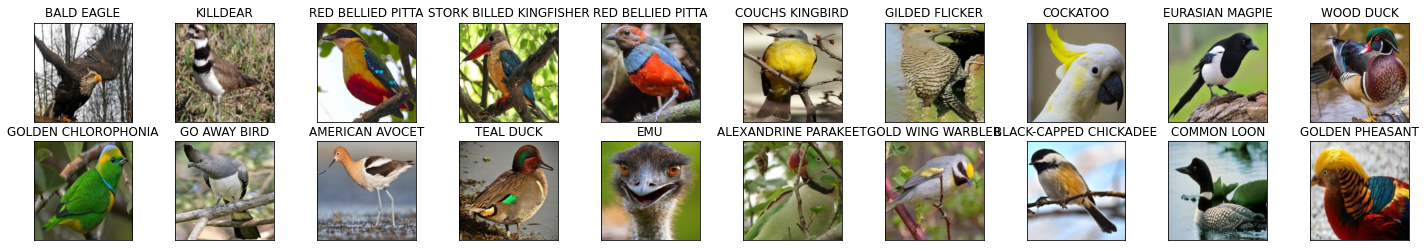

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
dataiter = iter(train_dl)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self, num_classes=275):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3,96,11,4)
        self.conv2 = nn.Conv2d(96,256,5,padding=2,groups=2)
        self.conv3 = nn.Conv2d(256,384,3,padding=1)
        self.conv4 = nn.Conv2d(384,384,3,padding=1, groups=2)
        self.conv5 = nn.Conv2d(384,256,3,padding=1, groups=2)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,num_classes)
 
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(F.relu(self.conv5(x)),(2,2))
        x = x.view(x.size(0),256*6*6)
        x = F.dropout(F.relu(self.fc1(x)),p=0.5)
        x = F.dropout(F.relu(self.fc2(x)),p=0.5)
        x = self.fc3(x)
        return x
device = torch.device("cuda")
print(device)
 
net = Model()
net.to(device)

cuda


Model(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=275, bias=True)
)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.1)
 
for epoch in range(20):
 
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, lables = data
        inputs = inputs.to(device)
        lables = lables.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d,%5d] loss: %.5f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


[1,  100] loss: 5.61660
[1,  200] loss: 5.61548
[1,  300] loss: 5.61500
[1,  400] loss: 5.61491
[1,  500] loss: 5.61360
[1,  600] loss: 5.61282
[2,  100] loss: 5.61129
[2,  200] loss: 5.61036
[2,  300] loss: 5.60925
[2,  400] loss: 5.60715
[2,  500] loss: 5.60447
[2,  600] loss: 5.59845
[3,  100] loss: 5.59010
[3,  200] loss: 5.58128
[3,  300] loss: 5.55544
[3,  400] loss: 5.53709
[3,  500] loss: 5.50292
[3,  600] loss: 5.43356
[4,  100] loss: 5.33596
[4,  200] loss: 5.24771
[4,  300] loss: 5.13776
[4,  400] loss: 5.05390
[4,  500] loss: 4.98008
[4,  600] loss: 4.87555
[5,  100] loss: 5.08531
[5,  200] loss: 4.90047
[5,  300] loss: 4.79466
[5,  400] loss: 4.60555
[5,  500] loss: 4.46445
[5,  600] loss: 4.41245
[6,  100] loss: 4.63891
[6,  200] loss: 4.25704
[6,  300] loss: 4.14397
[6,  400] loss: 4.07249
[6,  500] loss: 3.91123
[6,  600] loss: 3.79022
[7,  100] loss: 4.01922
[7,  200] loss: 3.68020
[7,  300] loss: 3.61567
[7,  400] loss: 3.48347
[7,  500] loss: 3.41811
[7,  600] loss: 

In [10]:

correct_predictions = 0
total_predictions = 0
for inputs, labels in valid_dl:
    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda() 
        outputs = net(inputs)
        prediction = outputs.argmax(1)
        correct_predictions += prediction.eq(labels.data).sum().item()
        total_predictions += labels.size(0)
print('Validation_Accuracy: %.2f %%' % (100 * (correct_predictions/total_predictions)))

Validation_Accuracy: 64.95 %


In [11]:

correct_predictions = 0
total_predictions = 0
for inputs, labels in test_dl:
    if torch.cuda.is_available():
           inputs, labels = inputs.cuda(), labels.cuda() 
           outputs = net(inputs)
           prediction = outputs.argmax(1)
           correct_predictions += prediction.eq(labels.data).sum().item()
           total_predictions += labels.size(0)
print('Test_Accuracy: %.2f %%' % (100 * (correct_predictions/total_predictions)))

Test_Accuracy: 65.82 %
